## Imports

In [52]:
import re
from matplotlib import pyplot as plt

## Extracting actual text to work with

In [53]:
def extractParagraphs(file) -> list[str]:
    '''
    This function take a raw text file, rids it of comments and empty lines, and returns a list of paragraphs.
    '''
    paragraphs = []
    current_paragraph = ''
    
    for line in file:
        if line.strip().startswith("#") or len(line) < 2:
            continue

        last_character = line[-2]
        if last_character in ['-', '=']:
            current_paragraph += line[:-2] # '=' and new line character
        else:
            current_paragraph += line[:-1] #new line character

        if last_character == '=':
            paragraphs.append(selectFirstVersionForEachWord(current_paragraph.strip()))
            current_paragraph = ''

    return paragraphs


def selectFirstVersionForEachWord(paragraph: str) -> str:
    '''
    Source text contains ambiguous signs. The researchers weren't certain which sign was intended, so they left all possibilities.
    This function returns the first possibility.
    Example: ... first|second|third ... -> ... first ... 
    '''
    return re.sub(r'\((.*?)\|.*?\)', r'\1', paragraph)

def extractWordsFromParagraphAndLower(paragraph: str) -> list[str]:
    '''
    This function takes a paragraph, splits it into words and makes them lowercase.
    Returns a list of words.
    '''
    # split by spaces, commas, dots, brackets, colons, semicolons and quotes
    return re.split(r'[\s,\.\[\]\{\}:;"]', paragraph.lower().replace('-', '').replace('_', ''))


In [54]:
def readFormattedText(path: str) -> list[str]:
    '''
    Eventually you get a list of pure words. No comments, no empty lines, no punctuation. 
    '''
    with open(path, 'r', encoding="utf-8") as f:
        return list(map(extractWordsFromParagraphAndLower, extractParagraphs(f)))



def readUnformattedText(path: str) -> list[str]:
    '''
    Eventually you get a list of unchanged words from the source text.
    '''
    with open(path, 'r', encoding="utf-8") as f:
        return map(processWordsInLine, (map(extractWordsFromParagraphAndLower, f.readlines())))


def processWordsInLine(line: list[str]) -> list[str]:
    '''
    Removes descriptive characters from a line and returns a list of words.
    '''
    return [one_word for one_word in map(lambda word: re.sub(r'[\(\)\-»«]', '', word), line) if len(one_word) > 0]

## Text analysis - NGrams

In [55]:
def countNGrams(text: list[str], n: int, min_count: int) -> dict[str, int]:
    '''
    Count the number of occurrences of desired ngrams.
    NGrams are sequences of n words, where n - number of words in sequence, min_count - minimal number of occurrences
    Returns a dict: {ngram: number of occurrences}
    '''
    ngrams = {}

    for paragraph in text:
        for i in range(len(paragraph) - n + 1):
            ngram = ' '.join(paragraph[i:i+n])
            if ngram not in ngrams:
                ngrams[ngram] = 0
            ngrams[ngram] += 1

    return {k: v for k, v in ngrams.items() if v >= min_count}

In [56]:

def getSortedNGramsAndCalculateScores(ngrams: dict[str, int]) -> list[tuple[str, int, float]]:
    '''
    Return a list of tuples: (ngram, number of occurrences, score)
    '''
    return [(ngram, count, (index + 1)/count) for index, (ngram, count) in enumerate(sorted(ngrams.items(), key=lambda x: x[1], reverse=True))]


## Graphs 

### NGram graphs

In [57]:
def plotNGramsCounts(ngrams: list[tuple[str, int, float]]) -> None:
    plt.figure(figsize=(20, 10))
    plt.bar(range(len(ngrams)), [count for _, count, _ in ngrams])
    plt.xticks(range(len(ngrams)), [word for word, _, _ in ngrams], rotation=90, fontsize=2)
    plt.show()

### Words graphs

In [58]:
def getWordsGraphs(text: list[str]) -> (dict[str, dict[str, int]], dict[str, dict[str, int]]):
    '''
    graph_forward - key is a word, value is a dictionary {next_word: number of occurrences}
    graph_backward - key is a word, value is a dictionary {previous_word: number of occurrences}
    '''
    graph_forward = {}
    graph_backward = {}

    for paragraph in text:
        for i in range(len(paragraph) - 1):
            word = paragraph[i]
            next_word = paragraph[i+1]

            if word not in graph_forward:
                graph_forward[word] = {next_word: 1}
            else:
                next_words = graph_forward[word]
                if next_word not in next_words:
                    next_words[next_word] = 1
                else:
                    next_words[next_word] += 1

            if next_word not in graph_backward:
                graph_backward[next_word] = {word: 1}
            else:
                previous_words = graph_backward[next_word]
                if word not in previous_words:
                    previous_words[word] = 1
                else:
                    previous_words[word] += 1

    return (graph_forward, graph_backward)


def filterGraphByRequiringMinimalDegreeAndCount(graph: dict[str, dict[str, int]], minimal_degree: int, minimal_count: int) -> dict[str, dict[str, int]]:
    '''
    Were we to plot the original graph, it would be illegible. This function filters the graph by requiring:
    - a minimal degree (smallest number of edges connected to any vertex in the graph)
    - count (minimal number of occurrences of a pair of words)
    Returns 
    '''
    return {k: v for k, v in graph.items() if len(v) >= minimal_degree and max(v.values()) >= minimal_count}


def getFilteredWordsGraph(text: list[str], minimal_degree: int, minimal_count: int) -> (dict[str, dict[str, int]], dict[str, dict[str, int]]):
    '''
    Main function. Returns two graphs: one for words preceding other words, one for words following other words.
    '''
    graph_forward, graph_backward = getWordsGraphs(text)
    filtered_graph_forward = filterGraphByRequiringMinimalDegreeAndCount(graph_forward, minimal_degree, minimal_count)
    filtered_graph_backward = filterGraphByRequiringMinimalDegreeAndCount(graph_backward, minimal_degree, minimal_count)

    all_words_preceding = set(filtered_graph_forward.keys())
    all_words_following = set(filtered_graph_backward.keys())

    return ({k: {word: count for word, count in v.items() if word in all_words_following} for k, v in filtered_graph_forward.items()},
            {k: {word: count for word, count in v.items() if word in all_words_preceding} for k, v in filtered_graph_backward.items()})

### Drawing

In [59]:
def drawBipartialGraph(graph: (dict[str, dict[str, int]], dict[str, dict[str, int]]), title: str, print_labels: bool = False):
    '''
    Draws a graph.
    '''
    plt.figure(figsize=(30, 30))
    plt.title(title)
    plt.axis('off')

    graph_network_forward, graph_network_backward = graph

    max_degree_first_word = max(map(len, graph_network_forward.values()))
    max_degree_second_word = max(map(len, graph_network_backward.values()))

    max_count= max(map(max, map(lambda x: x.values(), graph_network_forward.values())))

    all_words = set(graph_network_forward.keys())
    for words in graph_network_forward.values():
        all_words.update(words.keys())

    all_words_list = list(all_words)
    all_words_list.sort()

    word_to_index = {word: i for i, word in enumerate(all_words_list)}

    for word, words in graph_network_forward.items():
        for next_word in words.keys():
            count = graph_network_forward[word][next_word]
            count_scaled = count / max_count

            degree_scaled_first_word = len(words) / max_degree_first_word
            degree_scaled_second_word = len(graph_network_backward[next_word]) / max_degree_second_word

            first_word_y = word_to_index[word]
            second_word_y = word_to_index[next_word]

            plt.plot([0, 1], [first_word_y, second_word_y],
                     color=(0, 0,
                            count_scaled, 1))
            
            if print_labels:
                plt.text(0, first_word_y, word, horizontalalignment='right')
                plt.text(1, second_word_y, next_word, horizontalalignment='left')

    plt.show()

___________________________________________________________________________________

# Function calls

## Text 1: First Study Group transcribtions

In [60]:
for p in readFormattedText('FSG.txt'):
    print(p)

['fgag2', 'gdae', 'ar', 'gham', 'soe', 'sorg', '0d0rc2', 'gdor', 'soe8g2org', 'dzar', 'org', 'dair', 'tham', 'sor', 'ar', 'hzar', 'hzar', '8ala2gaiir', 'scdg', 'or', 'gdam', 'so8', 'hzoarg', 'hzc2', '8aram', '2g0om', 'ohccg', 'ohcar', 'roeohg', 'hzaar', '8am', 'odam', 'or', 'odal2airg', 'tcar', 'hzam', 'pzar', 'fzam']
['g8araisg']
['o8ar', 'sg', 'soe', 'pzog', 'og8ar', 's', '2', 'fzoam', 'so8arggscg', 'so8g', 'odto', 'g', 'ohtoe', 'tohzg', 'o2tg', '8an', 'tor', 'do28am', 'sor', 'fzoe', 'so8g']
['8an', '02', 'hco8g']
['g8an', 'pzc2am', 'oe2', 'pzcg', 'ghan', 'sosg', 'pzo8aec2odso', 'dsog', 'ohairn', 'ohcoe', 'odal', 'so8an', '2dzcg', '8amsog', 'dzcg', 'do8am', 'pzg', 'pz08aiie2', 'hzcg', 'sc', 'oe8an', '88an', 'om', 'toe', 'o8am', 'to8an', 't8g', 'odon', '80r', 'hzg', 'do88am', 'sdzcg', 'dzor', 'tor', 'scg', 'doe', 'toe', 'toe', 'dor', 'toeso', 'toe', 'so8al', 'dsg', 'dtg', '8or', 'to8am', 'so', 'docakgto', 'htcg', 'tcdan', 'sco', 'psoe', '8g8g8', 'hzg', '8aihzggho', 'soe', 'sc', 'do8sc

### Graphs

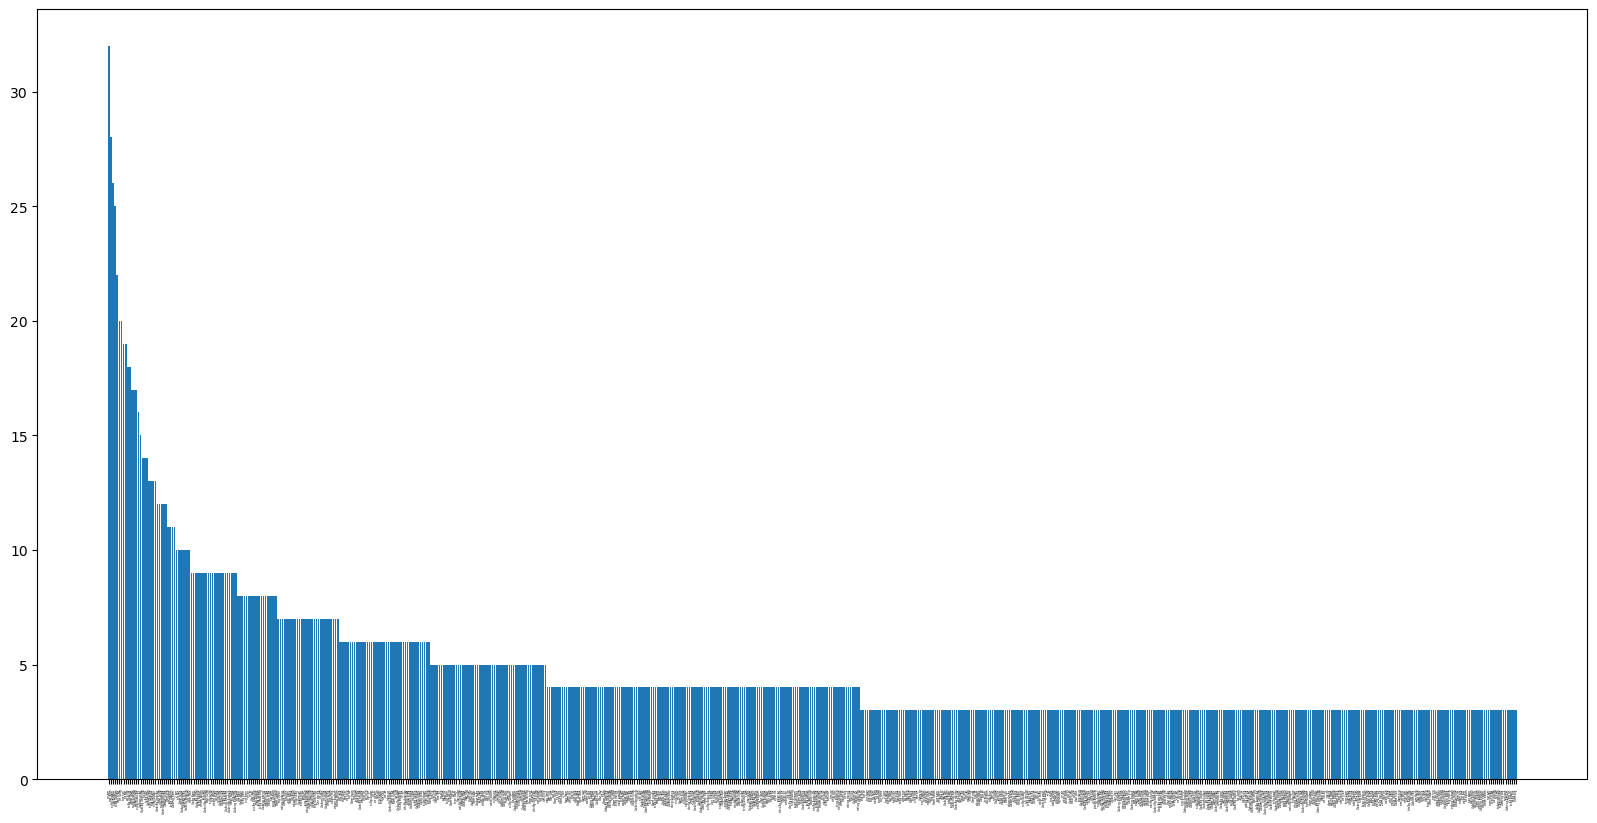

In [61]:
plotNGramsCounts(getSortedNGramsAndCalculateScores(countNGrams(readFormattedText('FSG.txt'), 2, 3)))

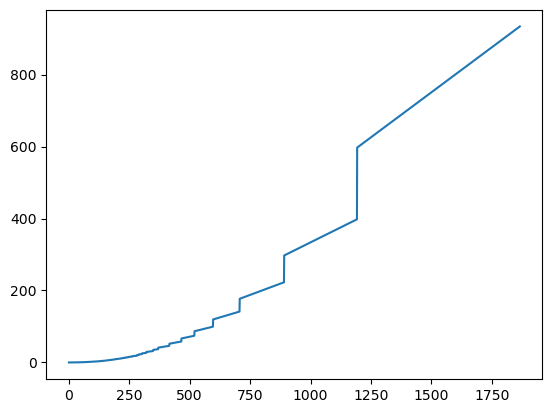

In [62]:
getSortedNGramsAndCalculateScores(countNGrams(readFormattedText('FSG.txt'), 1, 2))

plt.plot(list(map(lambda x: x[2], getSortedNGramsAndCalculateScores(countNGrams(readFormattedText('FSG.txt'), 1, 2)))))

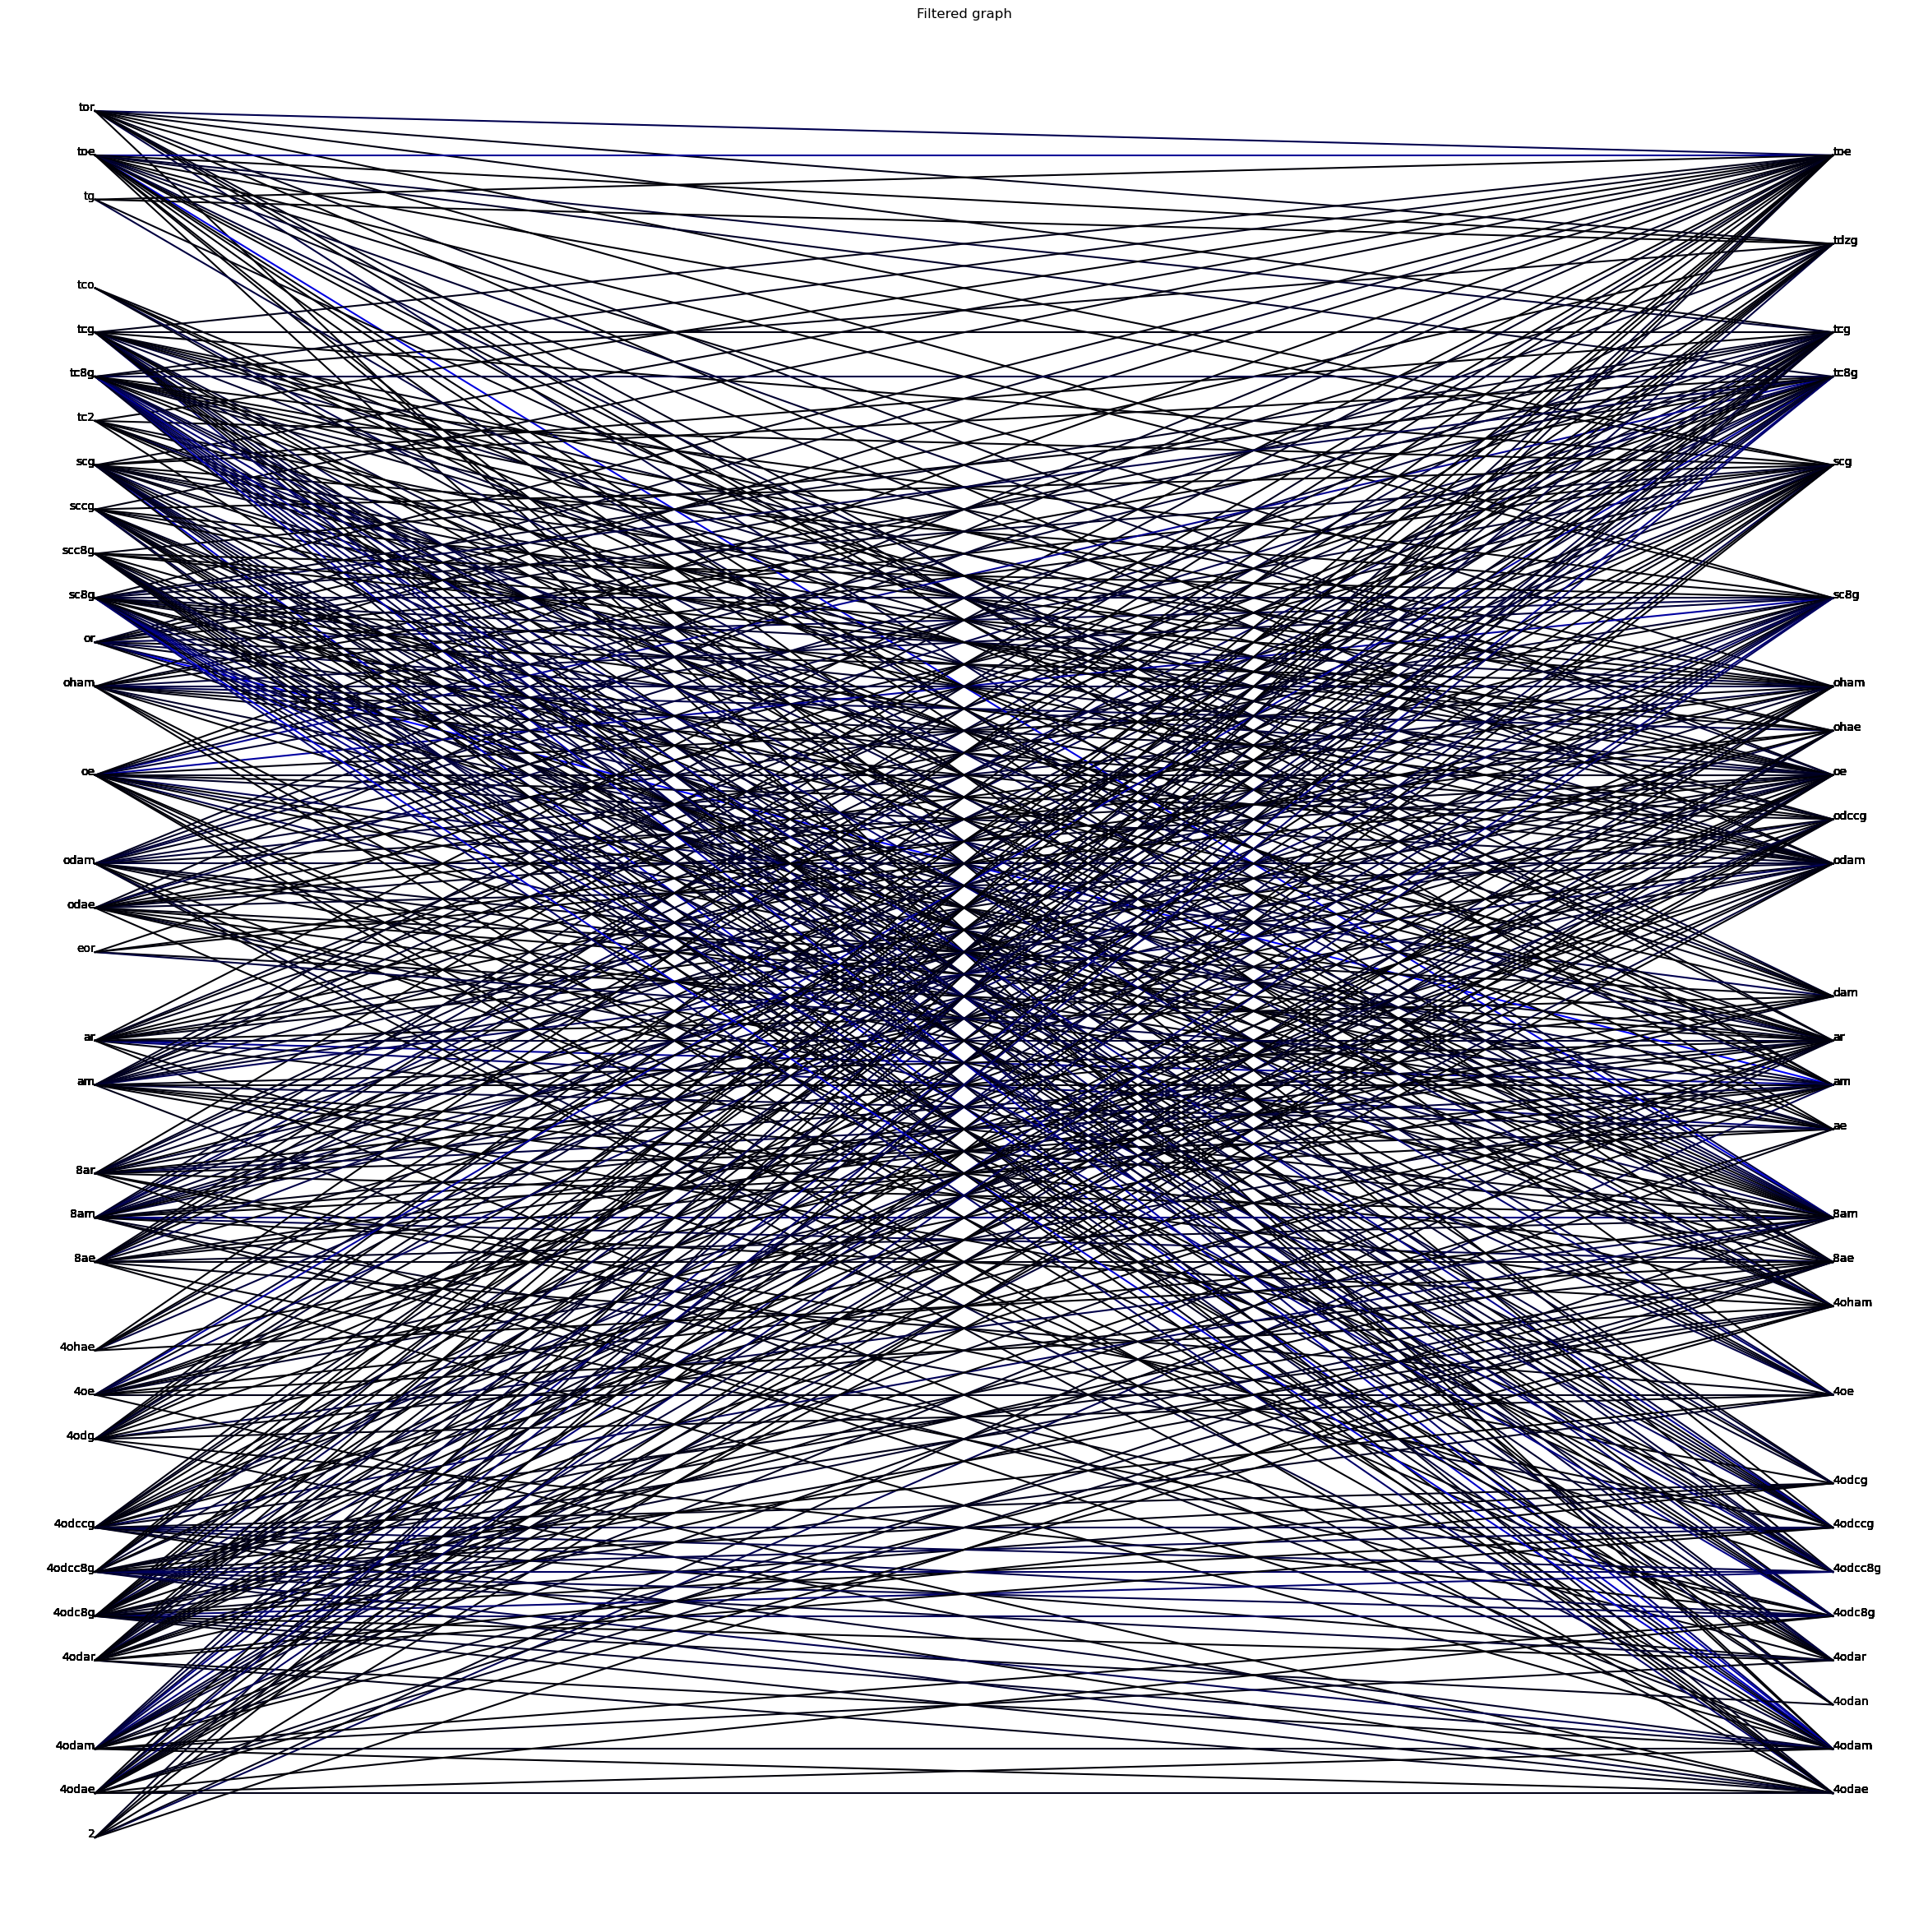

In [63]:
drawBipartialGraph(getFilteredWordsGraph(readFormattedText('FSG.txt'), 1, 8), 'Filtered graph', True)

## Text 2: Slovenian Solar System

In [64]:
for p in readUnformattedText('slovenian_solar_system.txt'):
    print(p)

['naše', 'osónčje', 'tudi', 'sónčev', 'sistém', 'ali', 'sestàv', 'je', 'sestav', 'astronomskih', 'teles', 'ki', 'ga', 'sestavljajo', 'zvezda', 'sonce', 'in', 'množica', 'drugih', 'teles', 'ki', 'kroži', 'okrog', 'njega', 'okrog', 'sonca', 'kroži', 'osem', 'planetov', 'izmed', 'katerih', 'je', 'tretji', 'planet', 'zemlja', 'naseljen', 'poleg', 'planetov', 'sestavlja', 'osončje', 'še', 'vsaj', '158', 'naravnih', 'satelitov', 'ki', 'krožijo', 'okrog', 'planetov', 'ter', 'večje', 'število', 'preostalih', 'majhnih', 'teles', 'kot', 'so', 'asteroidi', 'planetoidi', 'kometi', 'in', 'meteoroidi']
['naše', 'osončje', 'leži', 'v', 'spiralni', 'galaksiji', 'imenovani', 'rimska', 'cesta', 'oziroma', 'kar', 'galaksija', 'z', 'veliko', 'začetnico', 'obhodni', 'čas', 'njegovega', 'tira', 'je', 'galaktično', 'leto']
['izraz', 'osončje', 'ali', 'sončni', 'sistem', 'se', 'občasno', 'uporablja', 'tudi', 'za', 'druge', 'zvezdne', 'oziroma', 'planetne', 'sestave', 'čeprav', 'so', 'mnenja', 'o', 'tem', 'del

### Graphs

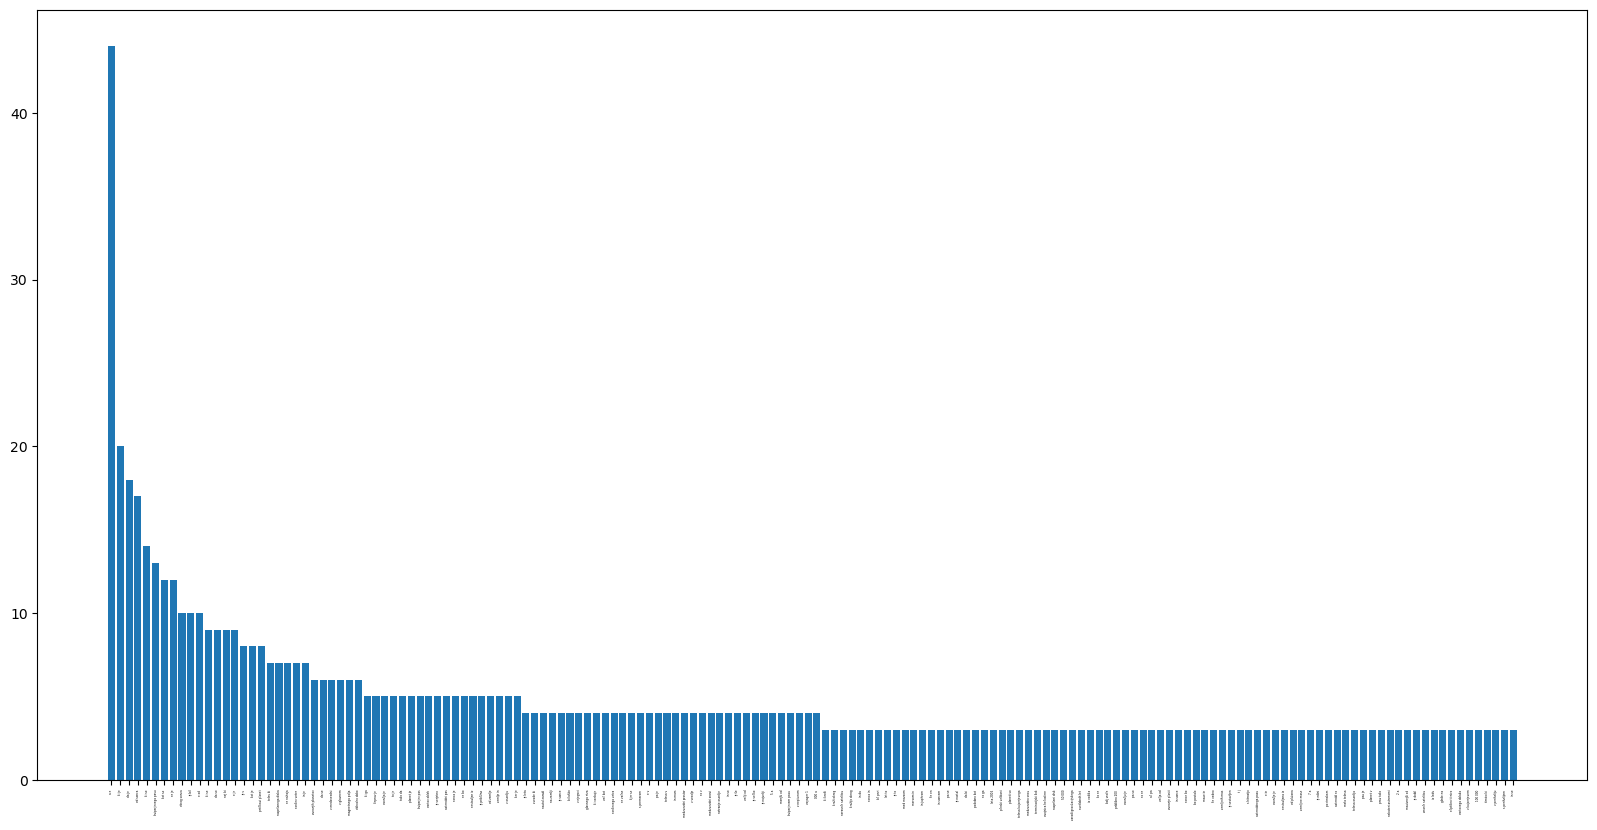

In [65]:
plotNGramsCounts(getSortedNGramsAndCalculateScores(countNGrams(readUnformattedText('slovenian_solar_system.txt'), 2, 3)))

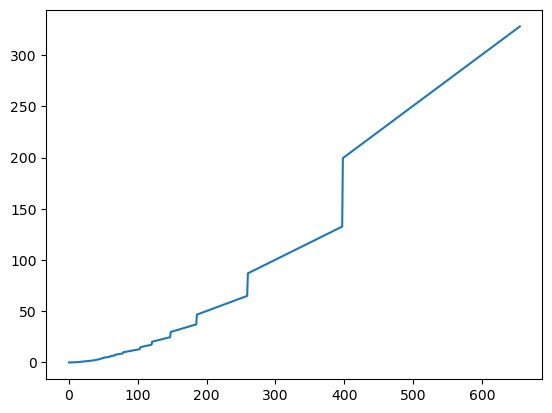

In [66]:
getSortedNGramsAndCalculateScores(countNGrams(readUnformattedText('slovenian_solar_system.txt'), 1, 2))
plt.plot(list(map(lambda x: x[2], getSortedNGramsAndCalculateScores(countNGrams(readUnformattedText('slovenian_solar_system.txt'), 1, 2)))))

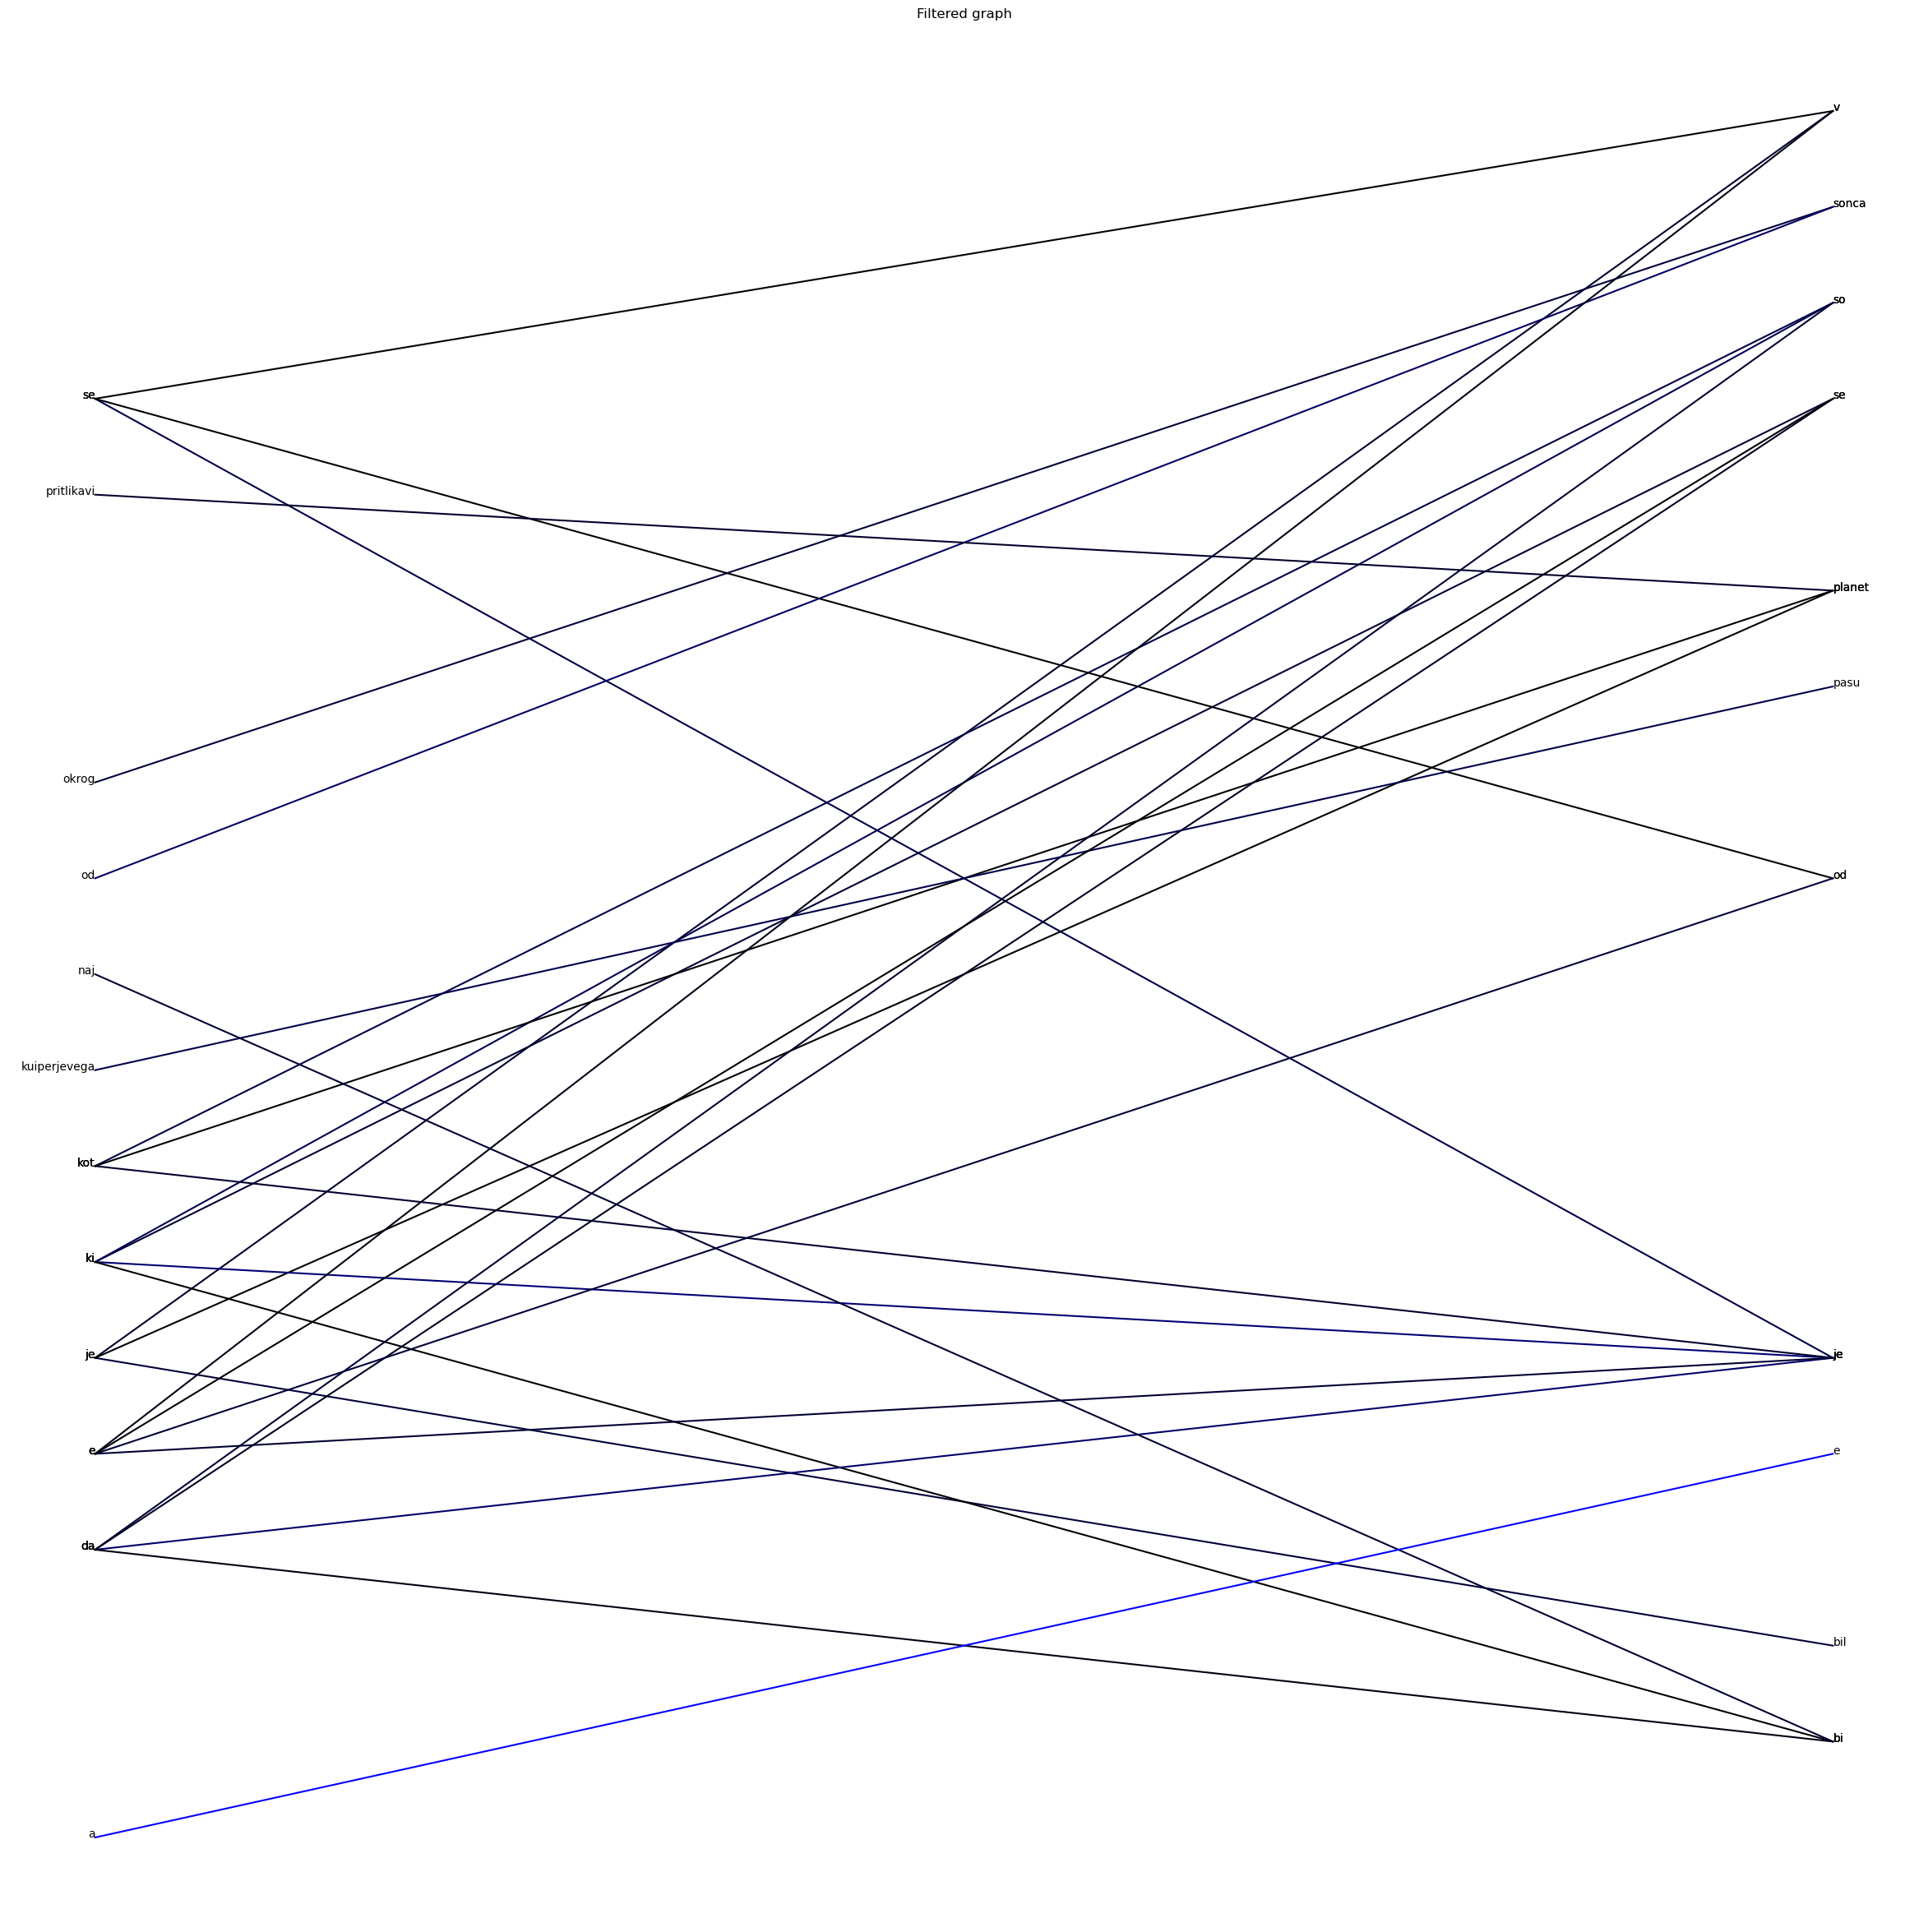

In [67]:
drawBipartialGraph(getFilteredWordsGraph(readUnformattedText('slovenian_solar_system.txt'), 1, 8), 'Filtered graph', True)